In [ ]:
WORKSPACE_NAME = 'quick-starts-ws-121376'

In [2]:
import os
NOTEBOOK_LOCATION = 'cloud' if os.environ.get('USER','') == 'azureuser' else 'local'

In [3]:
from azureml.core.authentication import InteractiveLoginAuthentication
if NOTEBOOK_LOCATION == 'local':
    TENANT_ID = input('Tenant ID: ')
    SUBSCRIPTION_ID = input('Subscription ID: ')
    RESOURCE_GROUP = input('Resource group: ')
    auth = InteractiveLoginAuthentication(force=True, tenant_id=TENANT_ID)

Performing interactive authentication. Please follow the instructions on the terminal.


WARNING - Note, we have launched a browser for you to login. For old experience with device code, use "az login --use-device-code"


You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.


In [4]:
from azureml.core import Workspace

if NOTEBOOK_LOCATION == 'local':
    ws = Workspace.get(
        name=WORKSPACE_NAME,
        subscription_id=SUBSCRIPTION_ID,
        resource_group=RESOURCE_GROUP
    )
else:
    ws = Workspace.get(WORKSPACE_NAME)
    
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Workspace name: quick-starts-ws-121376
Azure region: southcentralus
Subscription id: 30d182b7-c8c4-421c-8fa0-d3037ecfe6d2
Resource group: aml-quickstarts-121376


In [5]:
from azureml.core import Experiment

In [6]:
ws.compute_targets.keys()

dict_keys(['auto-ml', 'notebook121376'])

In [7]:
from azureml.core.compute import ComputeTarget, AmlCompute

# TODO: Create compute cluster
# Use vm_size = "Standard_D2_V2" in your provisioning configuration.
# max_nodes should be no greater than 4.

compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "aml-compute")
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 2)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('Using existing compute target: ' + compute_name)
else:
    compute_config = AmlCompute.provisioning_configuration(
        vm_size=vm_size,
        min_nodes=compute_min_nodes,
        max_nodes=compute_max_nodes
    )
    compute_target = ComputeTarget.create(ws, compute_name, compute_config)

Creating
Succeeded.......................
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


# HyperDrive

In [63]:
from azureml.train.sklearn import SKLearn
from azureml.train.hyperdrive.policy import BanditPolicy
from azureml.train.hyperdrive.sampling import RandomParameterSampling
from azureml.train.hyperdrive.parameter_expressions import loguniform, choice

hyd_est = SKLearn(
    source_directory='./',
    entry_script='train.py',
    compute_target=compute_target
)
'''
hyperparameters for sklearn.linear_model.LogisticRegression:
penalty='l2'   # ['l1', 'l2', 'elasticnet', 'none']
C=1.0   # [.001, .01, .1, 1, 10, 100, 1000]
solver='lbfgs'   # ['liblinear', 'saga']
max_iter=100   # [125, 150]
multi_class='auto'   # ['multinomial', 'ovr']
'''

# Specify parameter sampler
ps = RandomParameterSampling({
    "penalty": choice('l1', 'l2'),
    "C": loguniform(-4, 3),
    "solver": choice('lbfgs', 'saga')
})

# Specify a Policy for early stopping
policy = BanditPolicy(
    evaluation_interval = 10,
    slack_factor = 0.2
)

In [65]:
from azureml.train.hyperdrive.run import PrimaryMetricGoal
from azureml.train.hyperdrive.runconfig import HyperDriveConfig

# Create a HyperDriveConfig using the estimator, hyperparameter sampler, and policy.
hyperdrive_config = HyperDriveConfig(
    estimator=est,
    hyperparameter_sampling=ps,
    primary_metric_name='norm_macro_recall',
    primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
    policy=policy,
    max_total_runs=50,
    max_concurrent_runs=4
)

In [11]:
hyd_exp = Experiment(workspace=ws, name="udacity-project")

In [ ]:
compute_target.wait_for_completion(show_output=True)

In [68]:
hyd_run = hyd_exp.submit(config=hyperdrive_config)
hyd_run

Experiment,Id,Type,Status,Details Page,Docs Page
udacity-project,HD_097e76a8-9ecc-4308-acff-ce915cd23202,hyperdrive,Running,Link to Azure Machine Learning studio,Link to Documentation


In [76]:
hyd_best_run = hyper_run.get_best_run_by_primary_metric()
hyd_best_run_metrics = hyd_best_run.get_metrics()

print('Best Run Id: ', hyd_best_run.id)
print('Accuracy: ', hyd_best_run_metrics['accuracy'])
print('F1 score: ', hyd_best_run_metrics['AUC_weighted'])

Best Run Id:  HD_5c402c15-2bfc-4560-a34a-ebbed2a234aa_25
Accuracy:  0.9005563985837127
F1 score:  0.340710932260228


In [91]:
# Get your best run and save the model from that run.
hyd_model = hyd_best_run.register_model(
    model_name='Bank Marketing HyperDrive best model',
    model_path=os.path.join('outputs','model.joblib')
)

ModelPathNotFoundException: ModelPathNotFoundException:
	Message: Could not locate the provided model_path bankmarketing-amlproject in the set of files uploaded to the run: ['azureml-logs/55_azureml-execution-tvmps_a74db4c82d09cfa59fe38e5740c4f5fe87c1c4e2d428aa2028ead362d31a34b6_d.txt', 'azureml-logs/65_job_prep-tvmps_a74db4c82d09cfa59fe38e5740c4f5fe87c1c4e2d428aa2028ead362d31a34b6_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_a74db4c82d09cfa59fe38e5740c4f5fe87c1c4e2d428aa2028ead362d31a34b6_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'logs/azureml/108_azureml.log', 'logs/azureml/job_prep_azureml.log', 'logs/azureml/job_release_azureml.log']
                See https://aka.ms/run-logging for more details.
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Could not locate the provided model_path bankmarketing-amlproject in the set of files uploaded to the run: ['azureml-logs/55_azureml-execution-tvmps_a74db4c82d09cfa59fe38e5740c4f5fe87c1c4e2d428aa2028ead362d31a34b6_d.txt', 'azureml-logs/65_job_prep-tvmps_a74db4c82d09cfa59fe38e5740c4f5fe87c1c4e2d428aa2028ead362d31a34b6_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_a74db4c82d09cfa59fe38e5740c4f5fe87c1c4e2d428aa2028ead362d31a34b6_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'logs/azureml/108_azureml.log', 'logs/azureml/job_prep_azureml.log', 'logs/azureml/job_release_azureml.log']\n                See https://aka.ms/run-logging for more details."
    }
}

# AutoML

In [8]:
from azureml.data.dataset_factory import TabularDatasetFactory

# Create TabularDataset using TabularDatasetFactory
# Data is available at: 
# "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_train.csv"

data_file_source = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_train.csv"
ds = TabularDatasetFactory.from_delimited_files(path=data_file_source)

In [9]:
from train import clean_data

# Use the clean_data function to clean your data.
x, y = clean_data(ds)

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=42)

In [11]:
datastore = ws.get_default_datastore()
type(datastore)

azureml.data.azure_storage_datastore.AzureBlobDatastore

In [12]:
x_train.assign(target=y_train).to_csv('df_train.csv')

In [13]:
datastore.upload_files(['df_train.csv'], overwrite=True)

Uploading an estimated of 1 files
Uploading df_train.csv
Uploaded df_train.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_workspaceblobstore

In [14]:
train_ds = TabularDatasetFactory.from_delimited_files((datastore, 'df_train.csv'))

In [15]:
type(train_ds)

azureml.data.tabular_dataset.TabularDataset

In [16]:
from azureml.train.automl import AutoMLConfig

# Set parameters for AutoMLConfig
# NOTE: DO NOT CHANGE THE experiment_timeout_minutes PARAMETER OR YOUR INSTANCE WILL TIME OUT.
# If you wish to run the experiment longer, you will need to run this notebook in your own
# Azure tenant, which will incur personal costs.

aml_classification_metrics = [
    'accuracy',
    'AUC_weighted',
    'average_precision_score_weighted',
    'norm_macro_recall',
    'precision_score_weighted'
]

automl_config = AutoMLConfig(
    experiment_timeout_minutes=30,
    task='classification',
    primary_metric='norm_macro_recall',
    training_data=train_ds,
    label_column_name='target',
    compute_target=compute_target,
    n_cross_validations=5
)

In [17]:
compute_target.wait_for_completion(show_output=True)

Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [18]:
# Submit your automl run

from azureml.core.experiment import Experiment

automl_exp = Experiment(ws, "automl_test_experiment")
automl_run = automl_exp.submit(config=automl_config)
automl_run

Running on remote.


Experiment,Id,Type,Status,Details Page,Docs Page
automl_test_experiment,AutoML_9b2681b7-92ea-4e12-957d-2bcb464540a6,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [ ]:
from azureml.widgets import RunDetails
RunDetails(automl_run).show()

In [28]:
import pandas as pd

In [61]:
metrics = []
for r in automl_run.get_children():
    if r.get_status()=='Completed':
        run_metrics = r.get_metrics()
        run_metrics['run_id'] = r.get_details()['runId']
        run_metrics['algorithm'] = r.get_details()['properties']['run_algorithm']
        run_metrics['preprocessor'] = r.get_details()['properties']['run_preprocessor']
        metrics.append(run_metrics)
df_runs = pd.DataFrame(metrics)

In [30]:
import seaborn as sns
sns.set_style('whitegrid')

In [60]:
df_runs.columns

Index([], dtype='object')

In [62]:
df_runs['norm_macro_recall'].describe()

count    25.000000
mean      0.310044
std       0.159020
min       0.000000
25%       0.165899
50%       0.426672
75%       0.448029
max       0.490103
Name: norm_macro_recall, dtype: float64

In [64]:
df_runs_best = df_runs[df_runs['norm_macro_recall'] > df_runs['norm_macro_recall'].median()]

TypeError: tuple indices must be integers or slices, not str

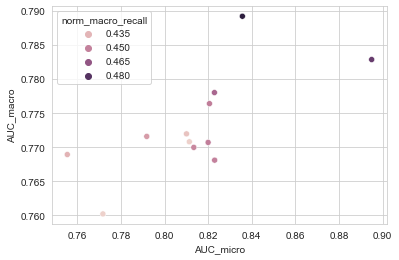

In [78]:
x_metric = 'AUC_micro'
y_metric = 'AUC_macro'
hue_metric = 'norm_macro_recall'

ax = sns.scatterplot(
    data=df_runs_best,
    x=x_metric,
    y=y_metric,
    hue=hue_metric
)
for row in df_runs_best.itertuples():
    ax.text(getattr(row, x_metric)+0.02, getattr(row, y_metric)+0.02, row['algorithm'])

In [39]:
df_runs_best

,norm_macro_recall,average_precision_score_weighted,balanced_accuracy,recall_score_micro,precision_score_weighted,average_precision_score_macro,weighted_accuracy,f1_score_weighted,matthews_correlation,AUC_weighted,...,average_precision_score_micro,recall_score_weighted,f1_score_macro,f1_score_micro,log_loss,precision_score_macro,AUC_macro,precision_score_micro,confusion_matrix,accuracy_table
0,0.490103,0.897186,0.745051,0.835552,0.883324,0.695756,0.858067,0.853589,0.391834,0.789223,...,0.772721,0.835552,0.682029,0.835552,0.520753,0.656845,0.789223,0.835552,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...
1,0.476025,0.896249,0.738012,0.832820,0.880928,0.694490,0.856368,0.851150,0.380728,0.782870,...,0.870719,0.832820,0.676808,0.832820,0.457604,0.652397,0.782870,0.832820,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...
3,0.426972,0.889283,0.713486,0.718231,0.871850,0.668360,0.719390,0.767965,0.286659,0.770802,...,0.759983,0.718231,0.589523,0.718231,0.560475,0.596263,0.770802,0.718231,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...
5,0.431074,0.891072,0.715537,0.728723,0.872142,0.672458,0.732071,0.775834,0.292670,0.771965,...,0.757004,0.728723,0.596631,0.728723,0.553637,0.599435,0.771965,0.728723,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...
8,0.451089,0.890921,0.725545,0.776675,0.874450,0.686002,0.789339,0.810905,0.324669,0.770707,...,0.770919,0.776675,0.630403,0.776675,0.545502,0.616899,0.770707,0.776675,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...
9,0.458607,0.895132,0.729303,0.786993,0.875673,0.690070,0.801316,0.818425,0.334939,0.778023,...,0.770801,0.786993,0.638875,0.786993,0.529368,0.622362,0.778023,0.786993,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...
10,0.448029,0.890550,0.724015,0.757945,0.874032,0.686443,0.766342,0.797448,0.313756,0.769977,...,0.765242,0.757945,0.617660,0.757945,0.554056,0.609899,0.769977,0.757945,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...
14,0.451314,0.893552,0.725657,0.762020,0.874507,0.685610,0.771030,0.800453,0.317480,0.776401,...,0.766393,0.762020,0.620818,0.762020,0.537281,0.611706,0.776401,0.762020,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...
16,0.441833,0.890221,0.720916,0.753263,0.873344,0.679923,0.761366,0.793864,0.309255,0.771588,...,0.747026,0.753263,0.614042,0.753263,0.796642,0.608402,0.771588,0.753263,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...
17,0.426972,0.884571,0.713486,0.718231,0.871850,0.655913,0.719390,0.767965,0.286659,0.760217,...,0.739337,0.718231,0.589523,0.718231,0.586597,0.596263,0.760217,0.718231,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...,aml://artifactId/ExperimentRun/dcid.AutoML_9b2...


In [ ]:
# Retrieve and save your best automl model.
automl_best_run = automl_run.get_best_run_by_primary_metric()
automl_best_run_metrics = automl_best_run.get_metrics()

print('Best Run Id: ', automl_best_run.id)
print('Accuracy: ', automl_best_run_metrics['accuracy'])
print('F1 score: ', automl_best_run_metrics['f1-score'])

model = automl_best_run.register_model(
    description='Bank Marketing AutoML best model'
)

In [27]:
compute_target.delete()
compute_target.wait_for_completion(show_output=True, is_delete_operation=True)

Deleting........
SucceededProvisioning operation finished, operation "Succeeded"
